In [170]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


## Load Visualisation Plugin
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set()

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")


# Data Preprocessing

In [171]:
# Import CSV
Customer_df=pd.read_csv("kaggle/Customer Acqusition.csv")
Repayment_df=pd.read_csv("kaggle/Repayment.csv")
Spend_df=pd.read_csv("kaggle/spend.csv")

# Make a Copy
Customer_copy=Customer_df.copy()
Repayment_copy=Repayment_df.copy()
Spend_copy=Spend_df.copy()


In [172]:
## Checking for missing data

# Customer_copy.isnull().sum()
# Repayment_copy.isnull().sum() - Missing Data
# Spend_copy.isnull().sum()

# Customer_copy.describe(include='all')

In [173]:

# Drop unnecessary columns, Correct the SL_No:, Drop NAN Rows, rename Repayment Columns Name
Repayment_copy = Repayment_copy.drop(labels='Unnamed: 4', axis=1)
Repayment_copy['SL No:'] = Repayment_copy.index+1
Repayment_copy = Repayment_copy.dropna()
Repayment_copy = Repayment_copy.rename(columns={"Month":"Repay_Date","Amount":"Repay_Amt","SL No:":"SL_No:"})
Repayment_copy['Repay_Date']=pd.to_datetime(Repayment_copy['Repay_Date'], format='%d-%b-%y', errors='ignore')
Repayment_copy['Repay_Month_Year'] = Repayment_copy['Repay_Date'].dt.to_period('M')


## Correct the spelling in Cus_df
Customer_copy = Customer_copy.rename(columns={"Product":"Tier"})
Customer_copy['Tier'] = Customer_copy['Tier'].replace('Platimum', 'Platinum')
Customer_copy = Customer_copy.rename(columns={"Limit":"Credit_Limit"})


## Correct the spelling, edit columns names and get date(month and years)
Spend_copy['Type']= Spend_copy['Type'].replace('PETRO','PETROL')
Spend_copy = Spend_copy.rename(columns={"Month":"Purchase_Date","Amount":"Spend_Amt","Sl No:":"SL_No:"})
Spend_copy['Purchase_Date']=pd.to_datetime(Spend_copy['Purchase_Date'], format='%d-%b-%y', errors='ignore')
Spend_copy['Purchase_Month_Year'] = Spend_copy['Purchase_Date'].dt.to_period('M')


In [174]:
#Function to categorize AgeGroup

# Create Age Group for Customer
def agegroup (age):
    if age < 20:
        return 'Teenager'
    elif age >=20 and age <60:
        return 'Adult'
    elif age >= 60:
        return 'OlderAdult'
    
# Credit Score Calculation    
def risk_model(row):
    # Initialize risk score
    risk_score = 0
    
    # Payment history
    if row['Repaid']:
        #true
        risk_score += 2
    else:
        #false
        risk_score -= 2
    
    # Credit Spent within their Limit
    limit_utilization = row['sum_Spend_Amt'] / row['max_Credit_Limit']
    if limit_utilization < 1:
        risk_score -= 1
    elif limit_utilization > 1:
        risk_score += 1
    
    return risk_score   
 
# Total Month to Years and Months    
def months_to_years_months(months):
    years = months // 12
    remaining_months = months % 12
    return f"{years} years and {remaining_months} months"  

def custom_colname(col):
    # If there's an aggregation (like 'count', 'max', 'sum', etc.), join them in the format you described.
    if col[1]:
        return f"{col[1]}_{col[0]}"
    # If not, just return the original column name.
    else:
        return col[0]
    
Customer_copy['AgeGroup'] = Customer_copy['Age'].apply(agegroup)


In [175]:
Customer_copy.head(5)

,No,Customer,Age,City,Tier,Credit_Limit,Company,Segment,AgeGroup
0,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdult
1,2,A2,71,CALCUTTA,Silver,100000.0,C2,Salaried_MNC,OlderAdult
2,3,A3,34,COCHIN,Platinum,10000.0,C3,Salaried_Pvt,Adult
3,4,A4,47,BOMBAY,Platinum,10001.0,C4,Govt,Adult
4,5,A5,56,BANGALORE,Platinum,10002.0,C5,Normal Salary,Adult


In [176]:
# Customer merge with Spend df

Customer_Spend_Merged = pd.merge(Customer_copy,Spend_copy,on=['Customer'],how='inner')
Customer_Spend_Merged.columns

Index(['No', 'Customer', 'Age', 'City', 'Tier', 'Credit_Limit', 'Company',
       'Segment', 'AgeGroup', 'SL_No:', 'Purchase_Date', 'Type', 'Spend_Amt',
       'Purchase_Month_Year'],
      dtype='object')

In [177]:
# All Merged

All_Merged = pd.merge(Customer_Spend_Merged,Repayment_copy,on=['Customer','SL_No:'],how='inner')
All_Merged.columns

Index(['No', 'Customer', 'Age', 'City', 'Tier', 'Credit_Limit', 'Company',
       'Segment', 'AgeGroup', 'SL_No:', 'Purchase_Date', 'Type', 'Spend_Amt',
       'Purchase_Month_Year', 'Repay_Date', 'Repay_Amt', 'Repay_Month_Year'],
      dtype='object')

<h2>Cilent Composition</h2>

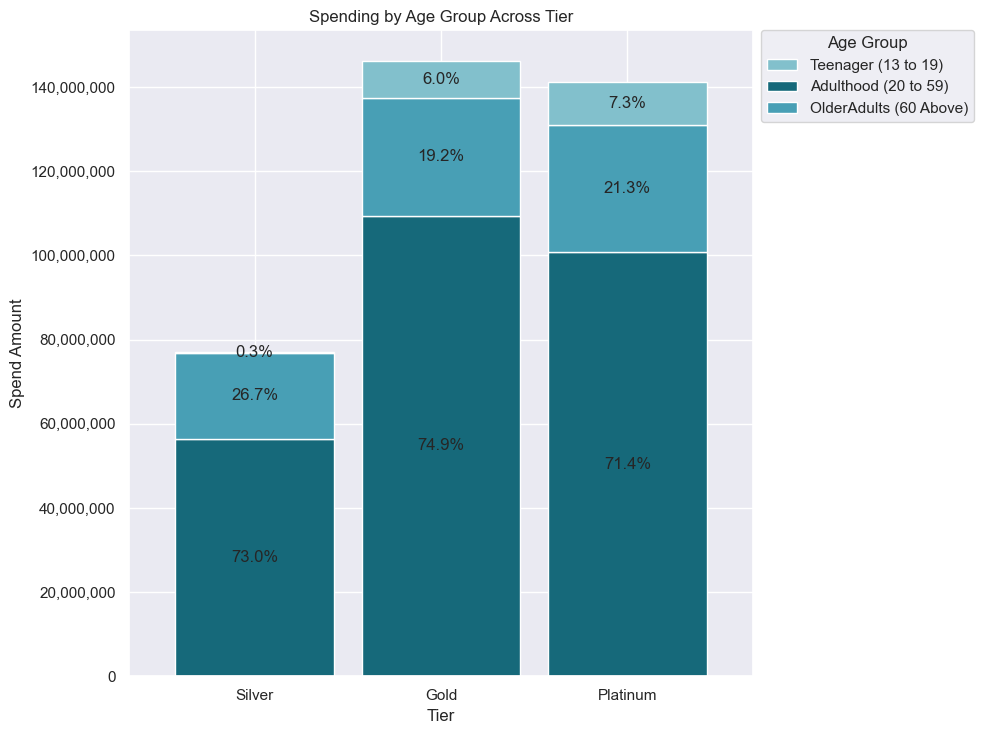

In [204]:
## Sort Customer by Tier Arcoss Age Group based on Total Spent Amount
Cust_Spend_GrpBy_Age_Tier = Customer_Spend_Merged.groupby(['AgeGroup','Tier'])['Spend_Amt'].sum().reset_index()


stack_color_palette=['#16697a','#489fb5','#82c0cc']
pivot_data = Cust_Spend_GrpBy_Age_Tier.pivot(index='Tier', columns='AgeGroup', values='Spend_Amt')

ax = pivot_data.loc[['Silver', 'Gold', 'Platinum']].plot(kind='bar',stacked=True,figsize=(10,7.5),color=stack_color_palette, width=0.85)

# Set the order of x-axis ticks
preferred_order_tier = ['Silver', 'Gold', 'Platinum']


# Set x and y labels
plt.xlabel('Tier')
plt.xticks(rotation=0)
ax.set_xticklabels(preferred_order_tier)

plt.ylabel('Spend Amount')
# Format y-axis ticks with thousands separator
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)


# Set the order and title for legends
handles, labels = ax.get_legend_handles_labels()
preferred_order_agegroup = ['Teenager', 'Adult', 'OlderAdult']
labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: preferred_order_agegroup.index(x[0])))


# Rename legends and adjust position
labels = ['Teenager (13 to 19)', 'Adulthood (20 to 59)', 'OlderAdults (60 Above)']
ax.legend(handles, labels, title='Age Group', loc='upper left', bbox_to_anchor=(1, 1.0125))

# Annotate the bars
for idx, label in enumerate(preferred_order_tier):
    total = pivot_data.loc[label].sum()  # total amount for this tier
    y_offset = 0  # To keep track of where to put text in the y-axis
    for col in pivot_data.columns:
        value = pivot_data.loc[label, col]
        if value == 0:  # Skip zero values
            continue
        percentage = (value / total) * 100  # Calculate the percentage
        y_pos = y_offset + (value / 2)  # Position to place text in y-axis
        ax.text(idx, y_pos, f"{percentage:.1f}%", ha='center', va='center')
        y_offset += value # Increase the y_offset for next iteration


plt.title('Spending by Age Group Across Tier')
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


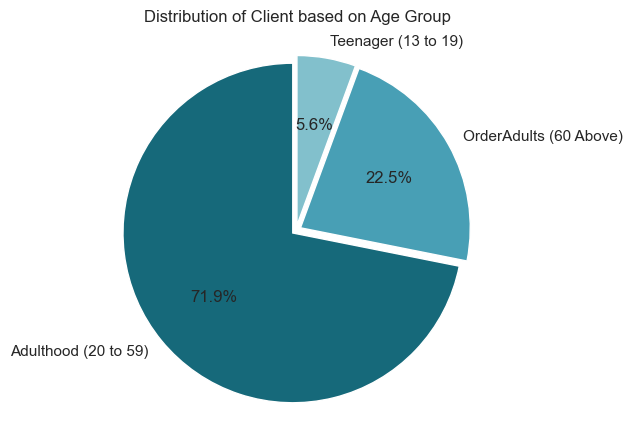

In [205]:
Count_AgeGroup = Customer_Spend_Merged['AgeGroup'].value_counts()
Count_AgeGroup_Labels = ['Adulthood (20 to 59)','OrderAdults (60 Above)','Teenager (13 to 19)']

# Only "explode" the 2nd slice
explode = (0.025, 0.03, 0.03)

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(Count_AgeGroup, labels=Count_AgeGroup_Labels, autopct='%1.1f%%', startangle=90 ,colors=stack_color_palette, explode=explode)
plt.title('Distribution of Cilent based on agegroup')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Client based on Age Group', y=1.02)  # Adjust the y parameter to move the title up
plt.axis('equal')

# Show the plot
plt.show()

<h2> Geographic distribution </h2>

In [180]:
CS_Groupby_City_Tier = Customer_Spend_Merged.groupby(['City','Tier']).size().reset_index(name='No')


Tree_fig = px.treemap(CS_Groupby_City_Tier,path=['City'],values='No')

# Update hover template for formatting
Tree_fig.update_traces(
    texttemplate='<b>%{label}</b><br>Population:%{value:}',
    textfont=dict(
        size=13,
        color="#050505"
    )
)

# Update layout for better visualization
Tree_fig.update_layout(
    title="Geographic Distribution by Density",
    plot_bgcolor='white',
    margin=dict(l=0, r=0, t=20, b=20),
    title_x=0.5,
    title_y=0.95,
    hovermode=False
)

# Show the plot
Tree_fig.show()

## Categories with the most spending

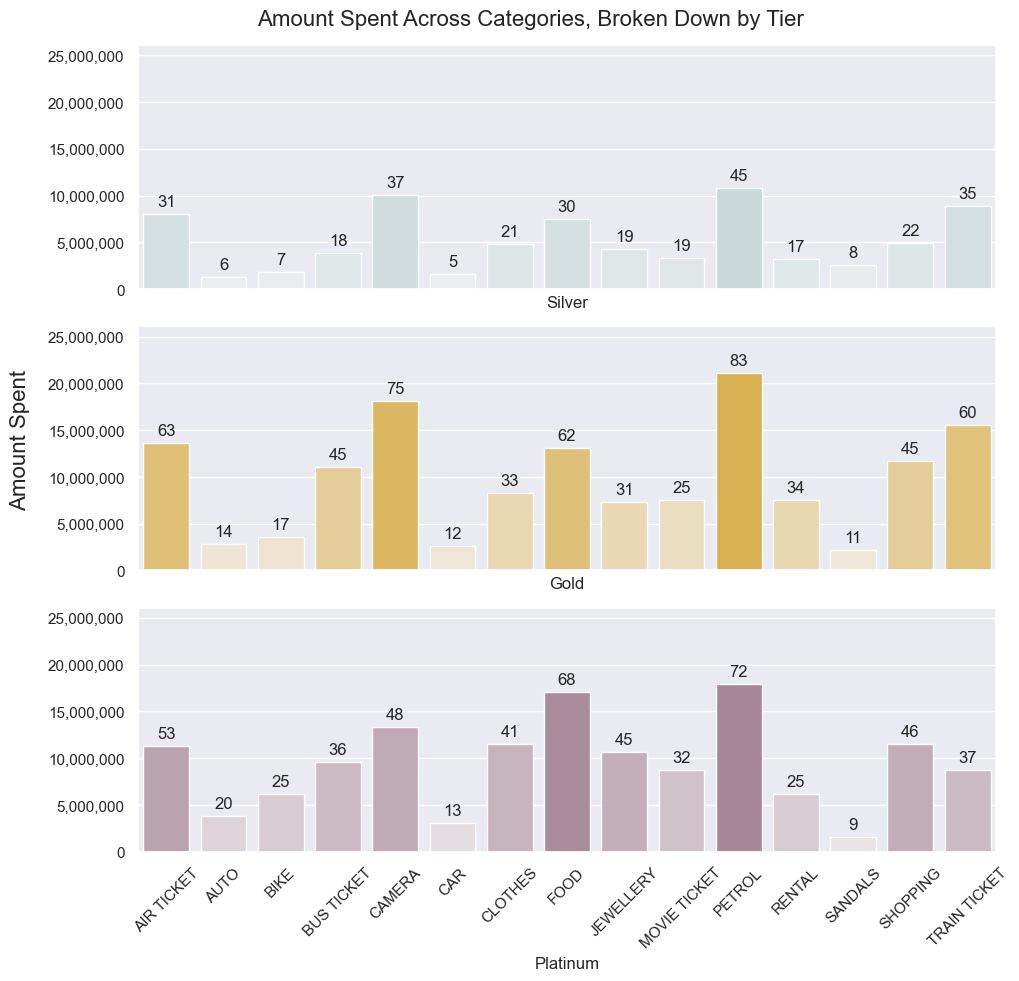

In [181]:
Categories_agg_funcs = {
    'Spend_Amt': ['sum','mean'],
    'Type':['count']
}

Categories_df = Customer_Spend_Merged.groupby(['Tier', 'Type']).agg(Categories_agg_funcs).reset_index()
Categories_df.columns =  [custom_colname(col) for col in Categories_df.columns]

Filtered_Teir_ax1 = Categories_df[Categories_df['Tier'] == 'Silver']
Filtered_Teir_ax2 = Categories_df[Categories_df['Tier'] == 'Gold']
Filtered_Teir_ax3 = Categories_df[Categories_df['Tier'] == 'Platinum']

teir_figure,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10, 10), sharex=True)

AxisY_count = Filtered_Teir_ax2['count_Type'].max()

# Create the Seaborn color palette
grad_color_s = sns.light_palette("#A4C7CE", reverse=False, as_cmap=True)
grad_color_g = sns.light_palette("#F0B93A", reverse=False, as_cmap=True)
grad_color_p = sns.light_palette("#A2708A", reverse=False, as_cmap=True)


# Normalize the 'Count' data and map to the color palette
palette_s = [grad_color_s(count/AxisY_count) for count in Filtered_Teir_ax1['count_Type']]
palette_g = [grad_color_g(count/AxisY_count) for count in Filtered_Teir_ax2['count_Type']]
palette_p = [grad_color_p(count/AxisY_count) for count in Filtered_Teir_ax3['count_Type']]

sns.barplot(data=Filtered_Teir_ax1, x='Type', y='sum_Spend_Amt',palette=palette_s,ax=ax1)
ax1.set_ylabel("Silver")

sns.barplot(data=Filtered_Teir_ax2, x='Type', y='sum_Spend_Amt',palette=palette_g,ax=ax2)
ax2.set_ylabel("Gold")

sns.barplot(data=Filtered_Teir_ax3, x='Type', y='sum_Spend_Amt',palette=palette_p,ax=ax3)
ax3.set_ylabel("Platinum")

# Format y-axis ticks with thousands separator
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)

Spend_Amt_Spacing = 5000000
ax1.set_ylim(0, Categories_df['sum_Spend_Amt'].max()+Spend_Amt_Spacing)
ax2.set_ylim(0, Categories_df['sum_Spend_Amt'].max()+Spend_Amt_Spacing)
ax3.set_ylim(0, Categories_df['sum_Spend_Amt'].max()+Spend_Amt_Spacing)

ax1.set(ylabel=None,xlabel='Silver')
ax2.set(ylabel=None,xlabel='Gold')
ax3.set(ylabel=None,xlabel='Platinum')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility


def annotate_bars(ax, data):
    for i, p in enumerate(ax.patches):
        count = data.iloc[i]['count_Type']
        ax.annotate(format(count, '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

annotate_bars(ax1, Filtered_Teir_ax1)
annotate_bars(ax2, Filtered_Teir_ax2)
annotate_bars(ax3, Filtered_Teir_ax3)


# Finalize the plot
teir_figure.suptitle('Amount Spent Across Categories, Broken Down by Tier', fontsize=16)
teir_figure.text(-0.02, 0.55, 'Amount Spent', va='center', rotation='vertical', fontsize=16)

plt.tight_layout(h_pad=1)
plt.show()


In [182]:
# Customer_Spend_Merged

In [183]:
# Cust_Spend_GrpBy_Type
# condition = (Customer_Spend_Merged['Tier'] == 'Gold') & (Customer_Spend_Merged['Type'] == 'PETROL')
# filtered_df = Customer_Spend_Merged.loc[condition]
# filtered_df['Spend_Amt'].sum()


In [184]:
# condition = (Cust_Spend_GrpBy_Type['Tier'] == 'Gold') & (Cust_Spend_GrpBy_Type['Type'] == 'PETROL')
# filtered_df = Cust_Spend_GrpBy_Type.loc[condition]
# filtered_df['Spend_Amt'].sum()


In [185]:
# Cust_Spend_GrpBy_Type

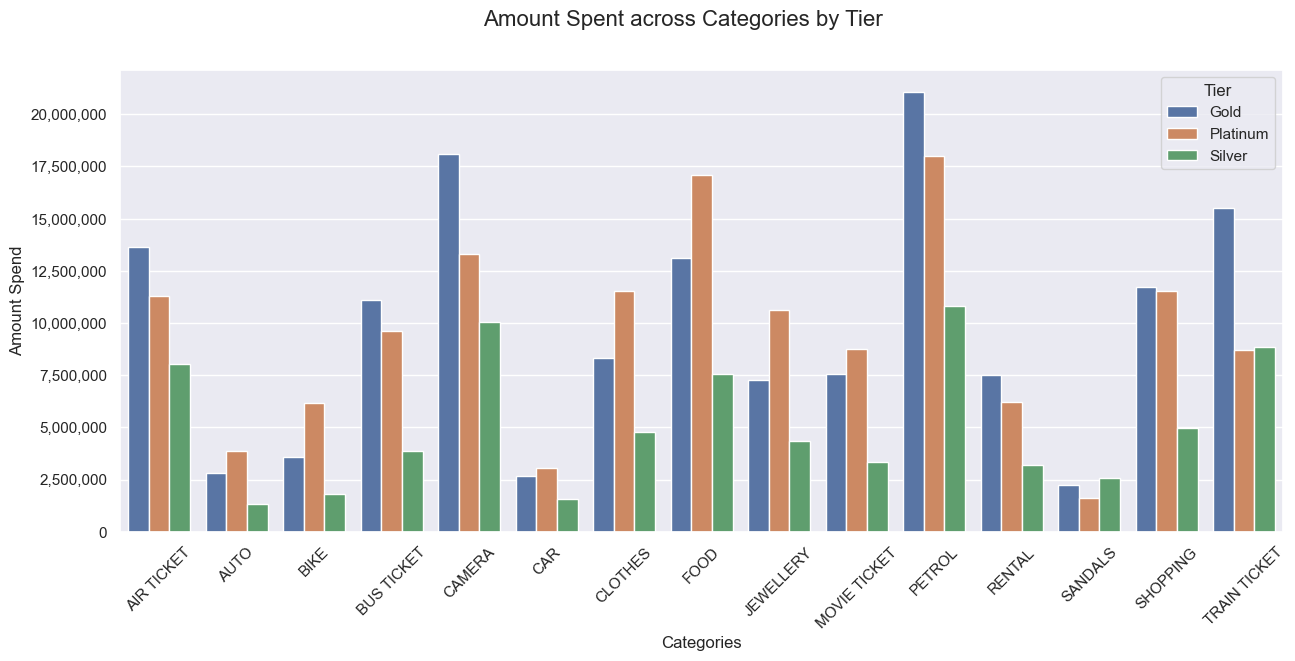

In [213]:
GrpBy_TierType_agg_funcs = {
    'Spend_Amt': ['sum'],
#     'AgeGroup':['max'],
#     'City':['max'],
#     'Segment':['max'],
#     'Customer':['max']
}

colors = ['#4C7CE','#F0B93A','#A2708A']


## Sort Customer by Tier Arcoss Age Group based on Total Spent Amount
GrpBy_TierType = Customer_Spend_Merged.groupby(['Type','Tier']).agg(GrpBy_TierType_agg_funcs).reset_index()
GrpBy_TierType.columns = GrpBy_TierType.columns.get_level_values(0)

plt.figure(figsize=(15,6))
sns.barplot(data=GrpBy_TierType, x='Type', y='Spend_Amt',hue="Tier", ci=None)  # Removed palette and ax=ax1


plt.xticks(rotation=45)

#format y axis to dollar
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.suptitle('Amount Spent across Categories by Tier', fontsize=16)
plt.ylabel("Amount Spend")
plt.xlabel("Categories")

plt.show()


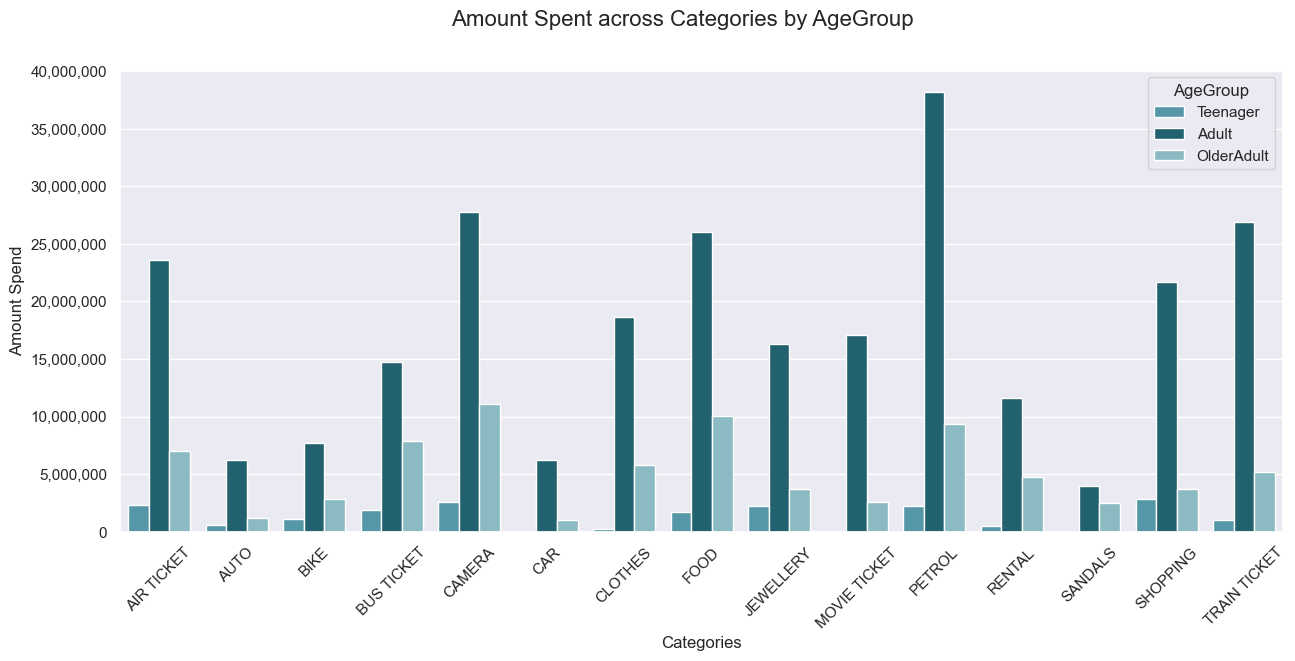

In [218]:
GrpBy_AgeGrp_Type_agg_funcs = {
    'Spend_Amt': ['sum'],
#     'AgeGroup':['max'],
#     'City':['max'],
#     'Segment':['max']
}

GrpBy_AgeGrp_Type_palette=['#489fb5','#16697a','#82c0cc']

## Sort Customer by Tier Arcoss Age Group based on Total Spent Amount
GrpBy_AgeGrp_Type = Customer_Spend_Merged.groupby(['AgeGroup','Type']).agg(GrpBy_AgeGrp_Type_agg_funcs).reset_index()
GrpBy_AgeGrp_Type.columns = GrpBy_AgeGrp_Type.columns.get_level_values(0)

plt.figure(figsize=(15,6))
sns.barplot(data=GrpBy_AgeGrp_Type, x='Type', y='Spend_Amt',hue="AgeGroup",hue_order=['Teenager', 'Adult', 'OlderAdult'], palette=GrpBy_AgeGrp_Type_palette, ci=None)  # Removed palette and ax=ax1


plt.xticks(rotation=45)

#format y axis to dollar
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.suptitle('Amount Spent across Categories by AgeGroup', fontsize=16)
plt.ylabel("Amount Spend")
plt.xlabel("Categories")

plt.show()


In [188]:
# condition = (Customer_Spend_Merged['Type'] == 'BIKE')
# filtered_df = Customer_Spend_Merged.loc[condition]
# # filtered_df

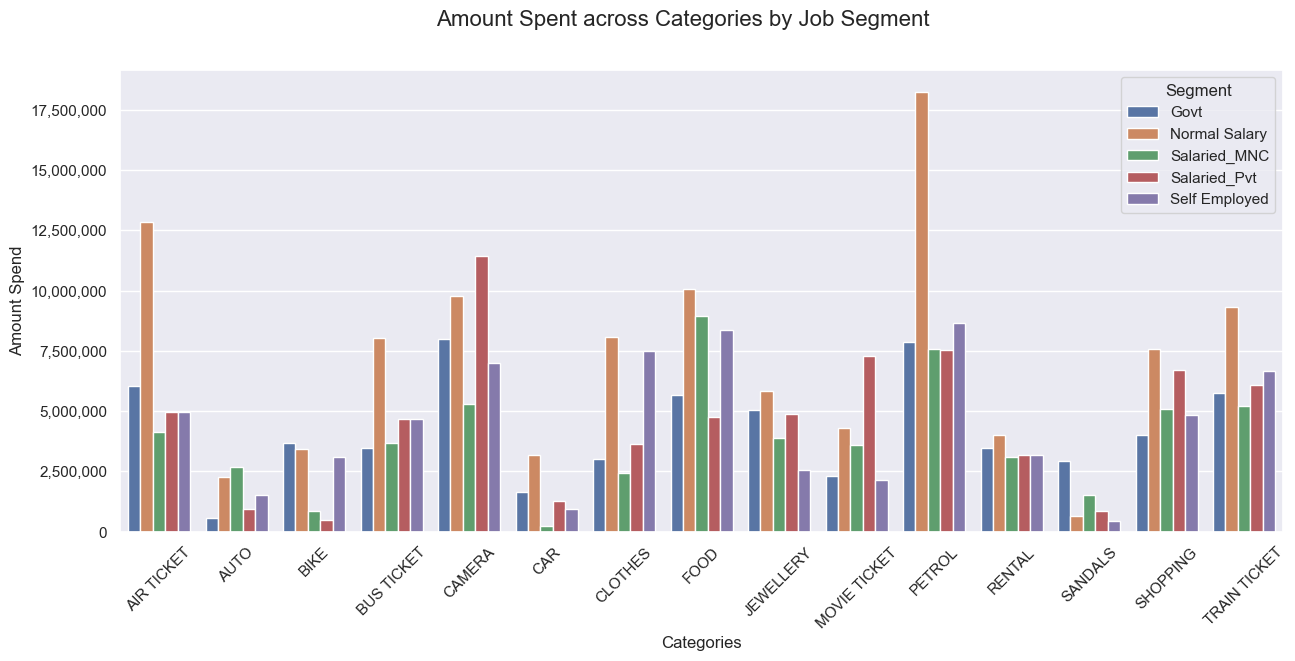

In [189]:
GrpBy_SegType_agg_funcs = {
    'Spend_Amt': ['sum'],
#     'AgeGroup':['max'],
#     'City':['max'],
#     'Segment':['max']
}

## Sort Customer by Tier Arcoss Age Group based on Total Spent Amount
GrpBy_SegType = Customer_Spend_Merged.groupby(['Segment','Type']).agg(GrpBy_SegType_agg_funcs).reset_index()
GrpBy_SegType.columns = GrpBy_SegType.columns.get_level_values(0)

plt.figure(figsize=(15,6))
sns.barplot(data=GrpBy_SegType, x='Type', y='Spend_Amt',hue="Segment", ci=None)  # Removed palette and ax=ax1


plt.xticks(rotation=45)

#format y axis to dollar
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.suptitle('Amount Spent across Categories by Job Segment', fontsize=16)
plt.ylabel("Amount Spend")
plt.xlabel("Categories")

plt.show()


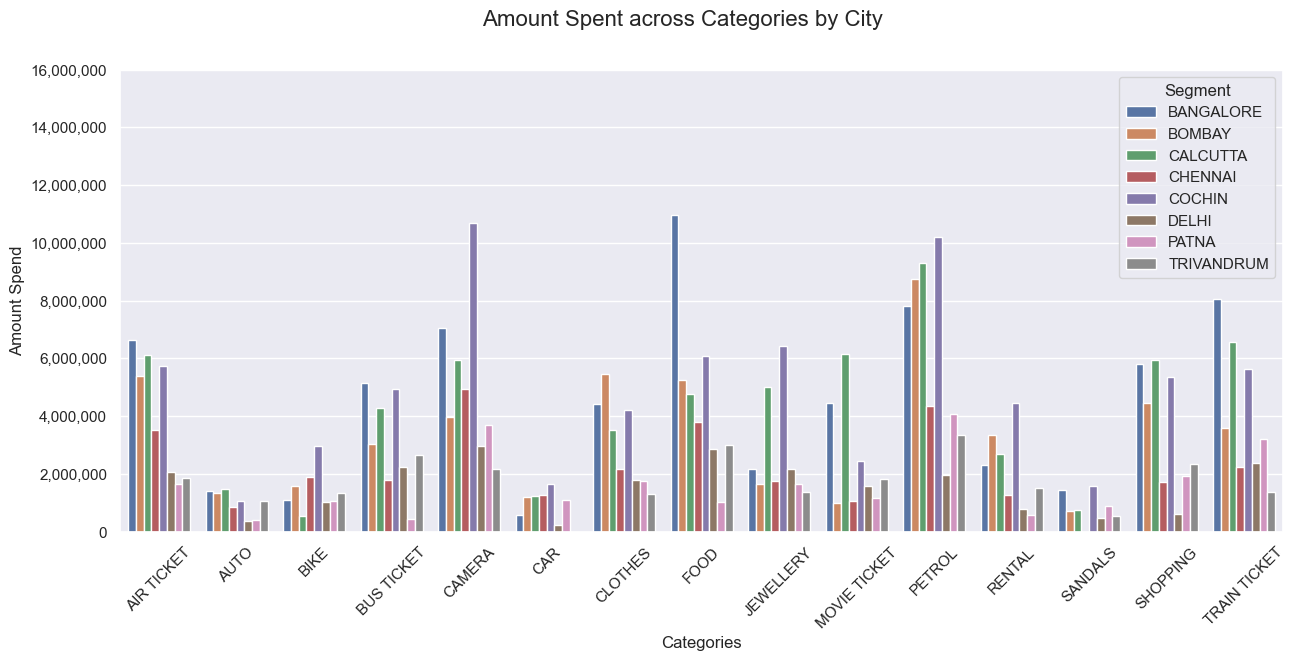

In [224]:
GrpBy_CityType_agg_funcs = {
    'Spend_Amt': ['sum'],
#     'AgeGroup':['max'],
#     'City':['max'],
#     'Segment':['max']
}

## Sort Customer by Tier Arcoss Age Group based on Total Spent Amount
GrpBy_CityType = Customer_Spend_Merged.groupby(['City','Type']).agg(GrpBy_CityType_agg_funcs).reset_index()
GrpBy_CityType.columns = GrpBy_SegType.columns.get_level_values(0)

plt.figure(figsize=(15,6))
sns.barplot(data=GrpBy_CityType, x='Type', y='Spend_Amt',hue="Segment", ci=None)  # Removed palette and ax=ax1


plt.xticks(rotation=45)

#format y axis to dollar
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim(0, 16000000)

plt.suptitle('Amount Spent across Categories by City', fontsize=16)
plt.ylabel("Amount Spend")
plt.xlabel("Categories")

plt.show()


<h2>Creating Credit Score</h2>

In [191]:
All_Merged.columns

Index(['No', 'Customer', 'Age', 'City', 'Tier', 'Credit_Limit', 'Company',
       'Segment', 'AgeGroup', 'SL_No:', 'Purchase_Date', 'Type', 'Spend_Amt',
       'Purchase_Month_Year', 'Repay_Date', 'Repay_Amt', 'Repay_Month_Year'],
      dtype='object')

In [192]:
# Define aggregation functions
agg_funcs = {
    'Spend_Amt': ['sum'],
    'Repay_Amt': ['sum'],
    'Purchase_Date': ['min'],  # Latest purchase date
    'Repay_Date': ['max'],  # Latest repayment date
    'Credit_Limit': 'max',
    'AgeGroup':['max'],
    'Age':['max'],
    'Segment':['max'],
    'Credit_Limit':['max'],
    'City':['max']
}

Monthly_grp= All_Merged.groupby(['Customer', 'Tier','Purchase_Month_Year']).agg(agg_funcs).reset_index()
Monthly_grp.columns = [custom_colname(col) for col in Monthly_grp.columns]

Monthly_grp['Repaid'] = Monthly_grp['sum_Repay_Amt'] > Monthly_grp['sum_Spend_Amt']
Monthly_grp['Risk_Group'] = Monthly_grp.apply(risk_model, axis=1)


Monthly_grp.head(5)

,Customer,Tier,Purchase_Month_Year,sum_Spend_Amt,sum_Repay_Amt,min_Purchase_Date,max_Repay_Date,max_Credit_Limit,max_AgeGroup,max_Age,max_Segment,max_City,Repaid,Risk_Group
0,A1,Gold,2004-01,2239644.04,2217905.74,2004-01-03,2006-04-01,500000.0,OlderAdult,76,Self Employed,BANGALORE,False,-1
1,A1,Gold,2004-02,52208.65,117964.43,2004-02-05,2004-02-05,500000.0,OlderAdult,76,Self Employed,BANGALORE,True,1
2,A1,Gold,2004-05,361141.31,187398.64,2004-05-05,2005-02-16,500000.0,OlderAdult,76,Self Employed,BANGALORE,False,-3
3,A1,Gold,2005-01,369694.07,165972.88,2005-01-17,2005-01-17,500000.0,OlderAdult,76,Self Employed,BANGALORE,False,-3
4,A1,Gold,2005-02,823969.80,1019295.17,2005-02-01,2006-09-03,500000.0,OlderAdult,76,Self Employed,BANGALORE,True,3


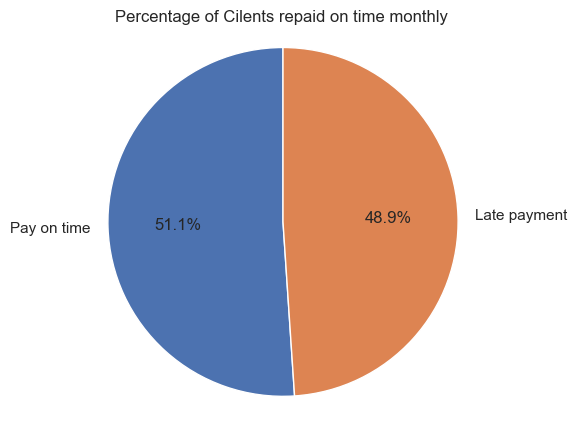

In [193]:
Count_Monthly_grp_Repaid = Monthly_grp['Repaid'].value_counts()

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(Count_Monthly_grp_Repaid, labels=['Pay on time', 'Late payment'], autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Cilents repaid on time monthly ')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

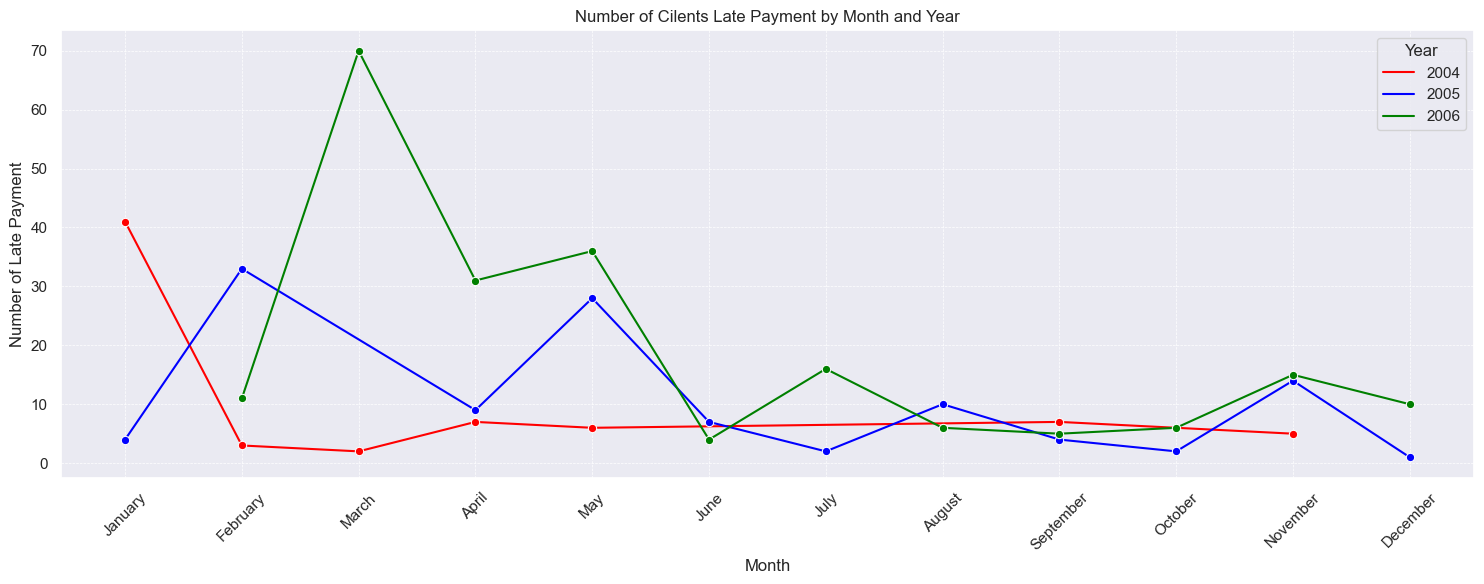

In [194]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']

Monthly_grp['Month'] = Monthly_grp['max_Repay_Date'].dt.month_name()
Monthly_grp['Year'] = Monthly_grp['max_Repay_Date'].dt.year

# Filter Monthly_grp Who Repaid is FALSE
Monthly_grp_F_Repaid = Monthly_grp[Monthly_grp['Repaid'] == False]

Count_Monthly_grp_F_Repaid = Monthly_grp_F_Repaid.groupby(['Month','Year']).size().reset_index(name='CountFalse')
Count_Monthly_grp_F_Repaid.columns = Count_Monthly_grp_F_Repaid.columns.get_level_values(0)
#[''.join(col).strip() for col in Count_Monthly_grp_F_Repaid.columns]

Count_Monthly_grp_F_Repaid['Month'] = pd.Categorical(Count_Monthly_grp_F_Repaid['Month'], categories=month_order, ordered=True)
Count_Monthly_grp_F_Repaid = Count_Monthly_grp_F_Repaid.sort_values(by=['Year', 'Month'])

# Plot using seaborn
plt.figure(figsize=(15,6))
sns.lineplot(x='Month', y='CountFalse',hue='Year', data=Count_Monthly_grp_F_Repaid, marker="o",palette=['red','blue','green'])

plt.title('Number of Cilents Late Payment by Month and Year')
plt.ylabel('Number of Late Payment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Year',loc='upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

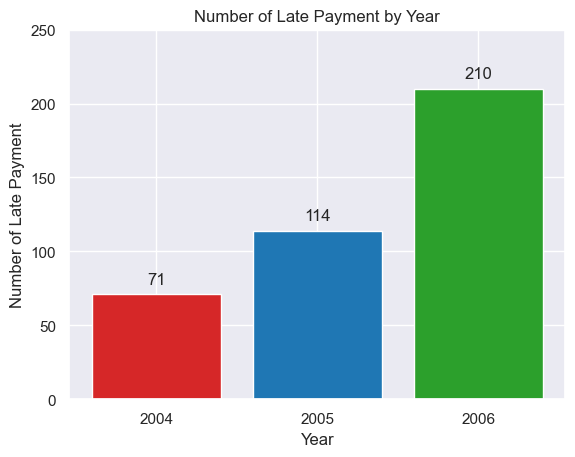

In [195]:
Count_Monthly_grp_F_Repaid = Monthly_grp_F_Repaid.groupby(['Year']).size().reset_index(name='No')

fig, ax = plt.subplots()

bar_labels =['2004','2005','2006']
bar_colors = ['tab:red', 'tab:blue', 'tab:green']


bars = ax.bar(Count_Monthly_grp_F_Repaid['Year'], Count_Monthly_grp_F_Repaid['No'], color=bar_colors)

# Displaying the count on each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, round(yval, 2), ha='center', va='bottom')
    
ax.set_ylabel('Number of Late Payment')
ax.set_xlabel('Year')
ax.set_title('Number of Late Payment by Year')

ax.set_xticks(Count_Monthly_grp_F_Repaid['Year'])
ax.set_ylim([0, 250])

plt.show()

In [196]:
Monthly_grp.columns

Index(['Customer', 'Tier', 'Purchase_Month_Year', 'sum_Spend_Amt',
       'sum_Repay_Amt', 'min_Purchase_Date', 'max_Repay_Date',
       'max_Credit_Limit', 'max_AgeGroup', 'max_Age', 'max_Segment',
       'max_City', 'Repaid', 'Risk_Group', 'Month', 'Year'],
      dtype='object')

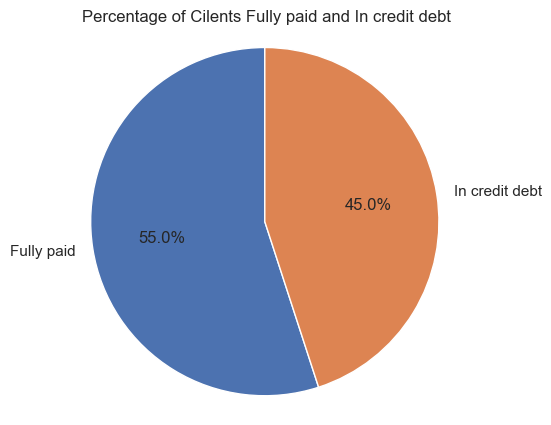

In [197]:
# Define aggregation functions
overall_agg_funcs = {
    'sum_Repay_Amt': ['sum'],
    'sum_Spend_Amt': ['sum'],
    'min_Purchase_Date': ['min'],  # Latest purchase date
}

Count_Customer_FullyPaid= Monthly_grp.groupby(['Customer']).agg(overall_agg_funcs).reset_index()
Count_Customer_FullyPaid.columns = Count_Customer_FullyPaid.columns.get_level_values(0)


Count_Customer_FullyPaid['InDebt'] = Count_Customer_FullyPaid['sum_Repay_Amt'] > Count_Customer_FullyPaid['sum_Spend_Amt']


Count_InDebt = Count_Customer_FullyPaid['InDebt'].value_counts()

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(Count_InDebt, labels=['Fully paid', 'In credit debt'], autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Cilents Fully paid and In credit debt')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

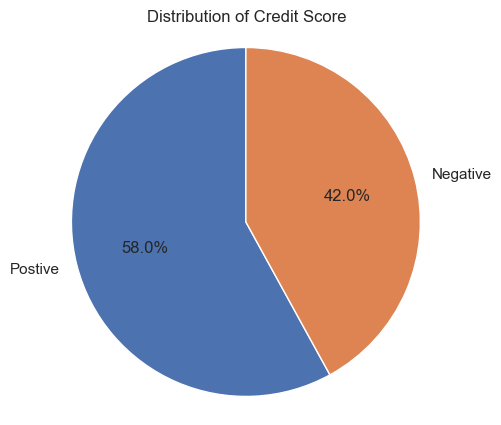

In [198]:
CreditScore_agg_funcs = {
    'Risk_Group': ['sum']
}

Count_CreditScore = Monthly_grp.groupby(['Customer']).agg(CreditScore_agg_funcs).reset_index()
Count_CreditScore.columns = Count_CreditScore.columns.get_level_values(0)

Count_CreditScore['Credit_Score'] = Count_CreditScore['Risk_Group'] >=1 #(Postive or Negative)

Pie_Count_CreditScore = Count_CreditScore['Credit_Score'].value_counts()

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(Pie_Count_CreditScore, labels=['Postive', 'Negative'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Credit Score')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

In [199]:
# import some preprocessing module
from sklearn import preprocessing

ScatterCredit_agg_funcs = {
    'sum_Spend_Amt': ['sum'],
    'sum_Repay_Amt':['sum'],
    'max_Age':['max'],
    'Risk_Group':['sum'],
    'Tier':['max'],
    'max_Segment':['max'],
    'max_City':['max']
}

Scatter_CreditScore = Monthly_grp.groupby(['Customer']).agg(ScatterCredit_agg_funcs).reset_index()
Scatter_CreditScore.columns = Scatter_CreditScore.columns.get_level_values(0)

Scatter_CreditScore['Repay_to_Spend_Raito']=np.sqrt(Scatter_CreditScore['sum_Repay_Amt']/Scatter_CreditScore['sum_Spend_Amt'])

preferred_order_tier = ['Silver', 'Gold', 'Platinum']

Scatter_CreditScore

,Customer,sum_Spend_Amt,sum_Repay_Amt,max_Age,Risk_Group,Tier,max_Segment,max_City,Repay_to_Spend_Raito
0,A1,5142702.76,4753691.67,76,-5,Gold,Self Employed,BANGALORE,0.961435
1,A10,3847424.65,3695647.52,54,-9,Gold,Normal Salary,CALCUTTA,0.980077
2,A100,224786.88,69551.19,36,-1,Silver,Salaried_MNC,COCHIN,0.556246
3,A11,4517227.69,5310934.03,35,-8,Gold,Normal Salary,COCHIN,1.084300
4,A12,8183050.64,8334760.16,51,8,Gold,Self Employed,BOMBAY,1.009227
...,...,...,...,...,...,...,...,...,...
95,A95,240401.50,369405.96,62,1,Gold,Salaried_MNC,PATNA,1.239605
96,A96,54729.66,310992.30,54,1,Silver,Salaried_Pvt,CHENNAI,2.383765
97,A97,139018.26,121874.90,58,-1,Platinum,Govt,TRIVANDRUM,0.936313
98,A98,284521.06,337815.57,51,3,Platinum,Normal Salary,CALCUTTA,1.089639


In [200]:
# Scatter_CreditScore['Tier'] = Scatter_CreditScore['Tier'].map({'Silver':1,'Gold':2,'Platinum':3})

# tier_mapping = {'Silver': 1, 'Gold': 2, 'Platinum': 3}
# Scatter_CreditScore['Tier_num'] = Scatter_CreditScore['Tier'].map(tier_mapping)

# sector_mapping = {'Self Employed': 1, 'Normal Salary': 2, 'Salaried_MNC': 3 ,'Salaried_Pvt':4,'Govt':5}
# Scatter_CreditScore['Segment_num'] = Scatter_CreditScore['max_Segment'].map(sector_mapping)

# city_mapping = {'BANGALORE': 0, 'CALCUTTA': 1, 'COCHIN': 2 ,'BOMBAY':3,'DELHI':4,'PATNA': 5 ,'CHENNAI':6,'TRIVANDRUM':7}
# Scatter_CreditScore['City_num'] = Scatter_CreditScore['max_City'].map(city_mapping)

# # Monthly_grp['max_City'].unique()
# Scatter_CreditScore

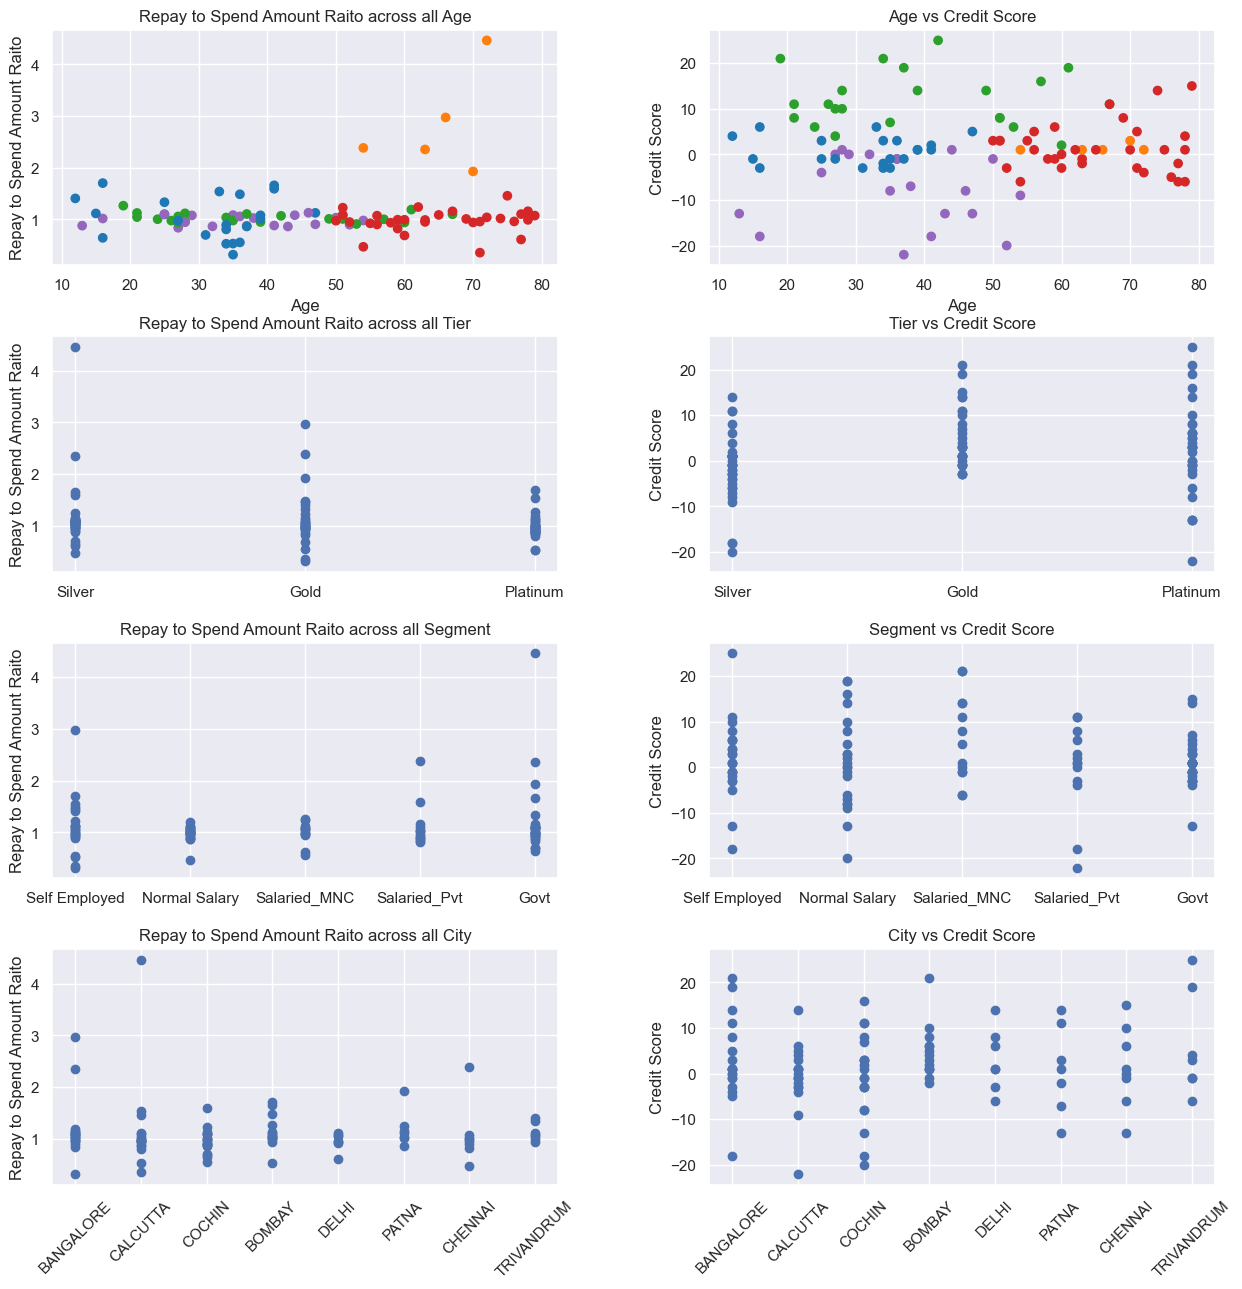

In [201]:
# Step 2: Data Standardization
# scaler = StandardScaler()
features_to_scale = ['max_Age','sum_Spend_Amt','Risk_Group','Repay_to_Spend_Raito']
#df_scaled = scaler.fit_transform(Scatter_CreditScore[features_to_scale])
df_scaled = preprocessing.scale(Scatter_CreditScore[features_to_scale])


# Step 3: Applying KMeans Clustering
kmeans = KMeans(n_clusters=5) 
Scatter_CreditScore['Cluster'] = kmeans.fit_predict(df_scaled)

distinct_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
Scatter_CreditScore['Color'] = Scatter_CreditScore['Cluster'].apply(lambda x: distinct_colors[x])

# Create a grid of subplots: 1 row, 3 columns
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

Scatter_CreditScore['Color'] = Scatter_CreditScore['Cluster'].apply(lambda x: distinct_colors[x])


# Visualization using the right DataFrame and columns
sc1 = axes[0,0].scatter(y=Scatter_CreditScore['Repay_to_Spend_Raito'], x=Scatter_CreditScore['max_Age'],c=Scatter_CreditScore['Color'])
axes[0,0].set_title('Repay to Spend Amount Raito across all Age')
axes[0,0].set_ylabel('Repay to Spend Amount Raito')

sc2 = axes[0,1].scatter(y=Scatter_CreditScore['Risk_Group'], x=Scatter_CreditScore['max_Age'], c=Scatter_CreditScore['Color'])
axes[0,1].set_title('Age vs Credit Score')
axes[0,1].set_ylabel('Credit Score')

sc3 = axes[1,0].scatter(y=Scatter_CreditScore['Repay_to_Spend_Raito'], x=Scatter_CreditScore['Tier'])
axes[1,0].set_title('Repay to Spend Amount Raito across all Tier')
axes[1,0].set_ylabel('Repay to Spend Amount Raito')

sc4 = axes[1,1].scatter(y=Scatter_CreditScore['Risk_Group'], x=Scatter_CreditScore['Tier'])
axes[1,1].set_title('Tier vs Credit Score')
axes[1,1].set_ylabel('Credit Score')

sc5 = axes[2,0].scatter(y=Scatter_CreditScore['Repay_to_Spend_Raito'], x=Scatter_CreditScore['max_Segment'])
axes[2,0].set_title('Repay to Spend Amount Raito across all Segment')
axes[2,0].set_ylabel('Repay to Spend Amount Raito')

sc6 = axes[2,1].scatter(y=Scatter_CreditScore['Risk_Group'], x=Scatter_CreditScore['max_Segment'])
axes[2,1].set_title('Segment vs Credit Score')
axes[2,1].set_ylabel('Credit Score')

sc5 = axes[3,0].scatter(y=Scatter_CreditScore['Repay_to_Spend_Raito'], x=Scatter_CreditScore['max_City'])
axes[3,0].set_title('Repay to Spend Amount Raito across all City')
axes[3,0].set_ylabel('Repay to Spend Amount Raito')

sc6 = axes[3,1].scatter(y=Scatter_CreditScore['Risk_Group'], x=Scatter_CreditScore['max_City'])
axes[3,1].set_title('City vs Credit Score')
axes[3,1].set_ylabel('Credit Score')



# Set x-label for all subplots
for ax in [axes[0,0], axes[0,1]]:
    ax.set_xlabel('Age')
    
# Set x-axis ticks and labels for both plots
for ax in [axes[1,0], axes[1,1]]:
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Silver', 'Gold', 'Platinum'])
    
for ax in [axes[3,0], axes[3,1]]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()
# Scatter_CreditScore


## Bankrupt Predication

## Ideal Number of Cluster

In [202]:
%%capture
wcss = []
# 'cl_num' is a that keeps track the highest number of clusters we want to use the WCSS method for. 
# We have it set at 10 right now, but it is completely arbitrary.
cl_num = 15
for i in range (2,cl_num+1):
    kmeans= KMeans(i)
    kmeans.fit(df_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
wcss

In [203]:
%%capture
number_clusters = range(1,cl_num)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')